## Goals of this notebook:

- How to use Keras models in scikit-learn.
- How to use grid search in scikit-learn.
- How to tune batch size and training epochs.
- How to tune optimization algorithms.
- How to tune learning rate and momentum.
- How to tune network weight initialization.
- How to tune activation functions.
- How to tune dropout regularization.
- How to tune the number of neurons in the hidden layer.


## Use Keras with hyperparmeters 
Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class.

To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the build_fn argument when constructing the KerasClassifier class.

Grid search is a model hyperparameter optimization technique.

In scikit-learn this technique is provided in the GridSearchCV class.

The GridSearchCV process will then construct and evaluate one model for each combination of parameters. Cross validation is used to evaluate each individual model.

Grid Search CV Parameters:

1. **Batch Size and Epochs**: The batch size in iterative gradient descent is the number of patterns shown to the network before the weights are updated. The number of epochs is the number of times that the entire training dataset is shown to the network during training.

2. **Optimizer**: tune the optimization algorithm used to train the network

3. **Learning Rate**: Learning rate controls how much to update the weight at the end of each batch

4. **Kernel Initializer**: network weight initialization

5. **Neural Activation**: The activation function controls the non-linearity of individual neurons and when to fire.

6. **Dropout**: Tuning the dropout rate for regularization in an effort to limit overfitting and improve the model’s ability to generalize.

7. **No. of Neurons**: The number of neurons in a layer is an important parameter to tune. A larger network requires more training and at least the batch size and number of epochs should ideally be optimized with the number of neurons.

Please refer to the following link for more details:
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


In [9]:
import os
import sys

import numpy as np
import pandas as pd

from sklearn.datasets import make_regression,make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier  

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True


In [10]:
def generateData():
    #Generate a random n-class classification problem.
    X, y = make_classification(n_samples=100,n_features=2, n_redundant=0,n_informative=2)
    return X,y

In [11]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

In [12]:
from sklearn.linear_model import Perceptron

def analyzeData(X, y):   
    ppn = Perceptron(max_iter=40, eta0=0.1, random_state=1)
    ppn.fit(X, y)

    plot_decision_regions(X=X, y=y,
                          classifier=ppn, test_idx=range(50, 100))
    plt.title('Sample Classification: decision regions in 2D only')
    plt.xlabel('C1')
    plt.ylabel('C2')
    plt.legend(loc='upper left')

    plt.tight_layout()
    #plt.savefig('images/03_01.png', dpi=300)
    plt.show()

In [13]:
# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adagrad',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    
    model = Sequential()
    model.add(Dense(10,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model

In [14]:
def mainDriver(X, y, pipeline, param_grid):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
    grid = GridSearchCV(pipeline, cv=3, param_grid=param_grid)
    grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid
        
#end def

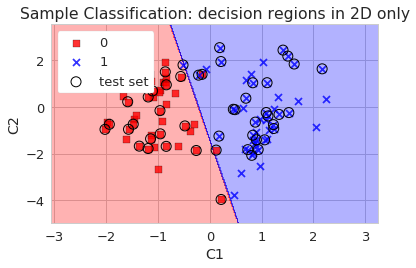

Best: -0.679073 using {'clf__batch_size': 10, 'clf__dropout': 0.2, 'clf__epochs': 8, 'clf__kernel_initializer': 'normal', 'clf__optimizer': 'rmsprop'}
-0.687919 (0.000518) with: {'clf__batch_size': 10, 'clf__dropout': 0.1, 'clf__epochs': 4, 'clf__kernel_initializer': 'uniform', 'clf__optimizer': 'rmsprop'}
-0.690019 (0.000721) with: {'clf__batch_size': 10, 'clf__dropout': 0.1, 'clf__epochs': 4, 'clf__kernel_initializer': 'uniform', 'clf__optimizer': 'adam'}
-0.685344 (0.003017) with: {'clf__batch_size': 10, 'clf__dropout': 0.1, 'clf__epochs': 4, 'clf__kernel_initializer': 'normal', 'clf__optimizer': 'rmsprop'}
-0.689478 (0.000082) with: {'clf__batch_size': 10, 'clf__dropout': 0.1, 'clf__epochs': 4, 'clf__kernel_initializer': 'normal', 'clf__optimizer': 'adam'}
-0.682255 (0.001451) with: {'clf__batch_size': 10, 'clf__dropout': 0.1, 'clf__epochs': 8, 'clf__kernel_initializer': 'uniform', 'clf__optimizer': 'rmsprop'}
-0.686225 (0.000799) with: {'clf__batch_size': 10, 'clf__dropout': 0.1, 

In [15]:
X, y  = generateData()

analyzeData(X, y)
    
# create parameter grid with various hyperparameters
# prefixed by model name: clf__
#turn on/off the needed parameters
param_grid = {
    'clf__batch_size': [10, 20, 40, 60],
    'clf__epochs':[4,8],
    'clf__optimizer':['rmsprop','adam',],
    #'clf__learn_rate' : [0.001, 0.01, 0.1, 0.2, 0.3],
    'clf__kernel_initializer':['uniform','normal'],
    #'clf__activation' : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    'clf__dropout':[0.1,0.2]
    #'clf__neurons' : [1, 5, 10, 15, 20, 25, 30]     
}

scaler = StandardScaler()   

# wrap the model using the function we created
clf = KerasRegressor(build_fn=create_model,verbose=0)
    
pipeline = Pipeline([
    ('preprocess',scaler),
    ('clf',clf)
])
    
if __name__ == '__main__':
    mainDriver(X, y, pipeline, param_grid)